In [1]:
import os
import datetime
import time

import geopandas as gp
import numpy as np
import pandas as pd
import rsfuncs as rs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from descartes import PolygonPatch
from itertools import combinations

from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dateutil.relativedelta import relativedelta
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()

# Load shapefiles 

In [2]:
# cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# CVW shapefile 
cvws = gp.read_file("../shape/cvws.shp")

# grace footprint
grace_sa = gp.read_file("../shape/argus_grace.shp")

# Casgem wells 
casgem = gp.read_file("/Users/aakash/Desktop/HyDRA/shape/casgem_wells.shp")
casgem.crs = {'init': 'epsg:4326'}
casgem = gp.sjoin(casgem,cvsa, op ='within')

# Stream gauges
gauges = gp.read_file("../shape/usgs_gauges.shp")
stations_in = [11446500, 11376550, 11423800, 11384000, 11390000 ,11451760,
            11372000, 11335000, 11376000, 11374000, 11383500, 11329500,
            11211300, 11424500, 11379500, 11407150, 11257500, 11209900,
            11192950, 11251600, 11225000, 11270900, 11381500, 11221700,
            11325500, 11384350, 11454000, 11370500, 11251000, 11302000, 
            11388000, 11382000, 11289650, 11199500, 11421000, 
            11208818, 11204100, 11200800, 11218400, 11289000, 11323500]

st_in = [str(x) for x in stations_in]
inflow = gauges[gauges['gauge_id'].isin(st_in)]

# Load outflow
outflow = gp.read_file('../shape/outflow.shp')

# Reservoirs
reservoirs = gp.read_file("../shape/reservoirs_grace.shp")

# Load water balance data 

In [3]:
# Load preprocessed RS Data (P, R, SM, SWE)
cvdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat_cv.csv"))
cvwdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat_cvws.csv"))

# Streamflow data (Qs; No inflow to CVWS) 
qs_in = rs.col_to_dt(pd.read_csv("../data/Qs_in_monthly.csv"))
qs_out = rs.col_to_dt(pd.read_csv("../data/Qs_out_monthly.csv"))
qs = rs.col_to_dt(pd.read_csv("../data/net_flow_monthly.csv"))
qs_in.columns = ['qs_in_km3']
qs_out.columns = ['qs_out_km3']
qs.columns = ['qs_net_cv_km3']

# Reservoir Data for CV and CVWS
Sres_cv = rs.col_to_dt(pd.read_csv('../data/cv_Sres.csv'))
Sres_cv.columns = ['Sres_cv']
Sres_cvws = rs.col_to_dt(pd.read_csv('../data/cvws_Sres.csv'))
Sres_cvws.columns = ['Sres_cvws']


In [4]:
# Load ET data processed using crop coefficient method (split into chunks in the ETkc folder)

files = [os.path.join("../data/ETkc",x) for x in os.listdir("../data/ETkc") if x.endswith(".csv")]
etdfs = [pd.read_csv(x) for x in files]

wdfs = [x.ETkc for x in etdfs]
petdfs = [x.petsum for x in etdfs]
aetdfs = [x.aetsum for x in etdfs]
kcdfs = [x.kc_mean for x in etdfs]
wET = pd.concat(wdfs, axis = 1)
aet = pd.concat(aetdfs, axis = 1)
pet = pd.concat(petdfs, axis = 1)
kc = pd.concat(kcdfs, axis = 1)

wets = wET.sum(axis=1)
pets = pet.sum(axis=1)
aets = aet.sum(axis=1)
kcs = kc.mean(axis = 1)

etdf = pd.DataFrame([wets, pets, aets, kcs]).T
etdf.index = pd.to_datetime(etdfs[0][etdfs[0].columns[0]])

etdf.columns = ['ETkc', 'pet', 'aet', "kc"]

# Load SSEBop ET data
ssebop_et =  pd.read_csv("../data/ssebop_et.csv")
ssebop_et = rs.col_to_dt(ssebop_et)

# Load Validation data

In [5]:
# Grace data
gracedf = pd.read_csv("../data/grace.csv")
gracedat = rs.col_to_dt(gracedf)
grace = pd.DataFrame(gracedat['grace'].dropna())

# Wells data (processed by zihan using Faunt 2009 Sy values )
wells = pd.read_csv("/Users/aakash/Desktop/HyDRA/data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)
wellcols = wells.columns

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)
wells['wells_ds_km3'] = wells[wells.columns[-1]] * 55000 * 1e-5
wells.drop(wellcols, axis = 1, inplace = True)

# c2vsim storage data (processed by Rich)
c2vs = pd.read_csv("/Users/aakash/Desktop/HyDRA/data/all_data_cv.csv")
c2vs.ds = c2vs.s.diff()
c2vsim_ds = pd.DataFrame(np.cumsum(rs.col_to_dt(c2vs)['s'].diff()))
c2vsim_ds.columns = ['c2vsim_ds']

In [6]:
cvdf.set_index(cvdf.index + MonthEnd(0), inplace = True)
cvwdf.set_index(cvwdf.index + MonthEnd(0), inplace = True)
etdf.set_index(etdf.index + MonthEnd(0), inplace = True)
ssebop_et.set_index(ssebop_et.index + MonthEnd(0), inplace = True)

In [7]:
wbdf = pd.concat([cvdf,cvwdf, etdf, ssebop_et, qs_in, qs_out, Sres_cv, Sres_cvws, grace, wells, c2vsim_ds], axis = 1)

# Make fig S1

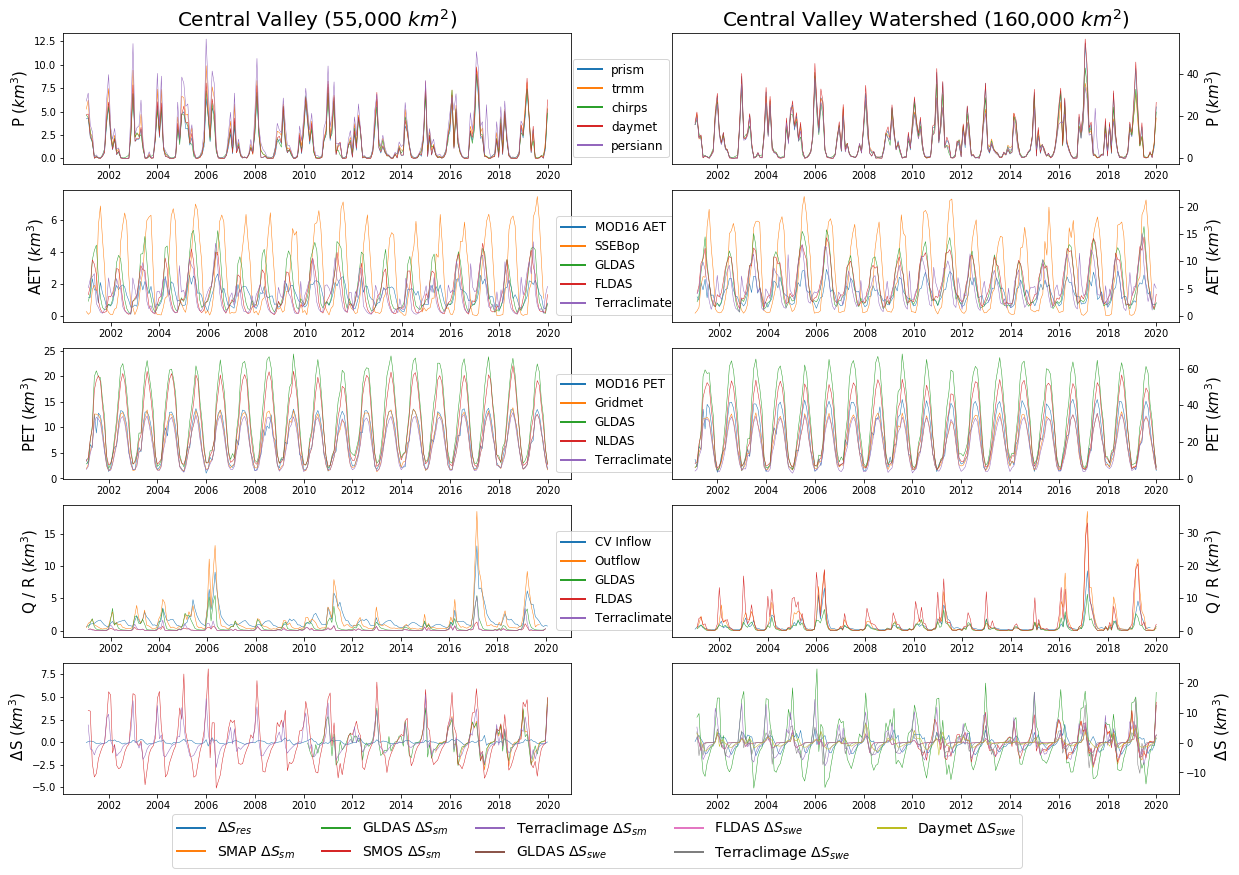

In [8]:
# Setup fig 

plotdf = wbdf[326:]

cols = ['Central Valley (55,000 $km^2$)', 'Central Valley Watershed (160,000 $km^2$)']
rows = ['P ($km^3$)', 'AET ($km^3$)', 'PET ($km^3$)', 'Q / R ($km^3$)', " $\Delta$S ($km^3$)" ]

nrows = len(rows)
ncols = len(cols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))

########################################################################
######################## PRECIP ########################################
########################################################################

# PRECIP CV
ax1 = plt.subplot(nrows, ncols, 1)
ax1.set_title(cols[0], size = 20)
ax1.plot(plotdf['p_prism'], label = "prism", linewidth = 0.5)
ax1.plot(plotdf['p_trmm'], label = "trmm", linewidth = 0.5)
ax1.plot(plotdf['p_chirps'], label = "chirps", linewidth = 0.5)
ax1.plot(plotdf['p_dmet'], label = "daymet", linewidth = 0.5)
ax1.plot(plotdf['p_psn'], label = "persiann", linewidth = 0.5)


# Legend in the center 
leg = ax1.legend(loc='upper right', bbox_to_anchor=(1.205, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax1.set_ylabel(rows[0], size = 15)

# PRECIP CVWS
ax2 = plt.subplot(nrows, ncols, 2)
ax2.set_title(cols[1], size = 20)
ax2.plot(plotdf['p_prism_cvws'], label = "prism", linewidth = 0.5)
ax2.plot(plotdf['p_trmm_cvws'], label = "trmm", linewidth = 0.5)
ax2.plot(plotdf['p_chirps_cvws'], label = "chirps", linewidth = 0.5)
ax2.plot(plotdf['p_dmet_cvws'], label = "daymet", linewidth = 0.5)
ax2.plot(plotdf['p_psn_cvws'], label = "persiann", linewidth = 0.5)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(rows[0], size = 15)

########################################################################
######################## AET ###########################################
########################################################################

# AET CV
ax3 = plt.subplot(nrows, ncols, 3)
ax3.plot(plotdf['aet_modis'], label = "MOD16 AET", linewidth = 0.5)
ax3.plot(plotdf['ssebop_cv'], label = "SSEBop", linewidth = 0.5)
ax3.plot(plotdf['aet_gldas'], label = "GLDAS", linewidth = 0.5)
ax3.plot(plotdf['aet_fldas'], label = "FLDAS", linewidth = 0.5)
ax3.plot(plotdf['aet_tc'], label = "Terraclimate", linewidth = 0.5)

# Legend in the center 
leg = ax3.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax3.set_ylabel(rows[1], size = 15)

# AET CVWS
ax4 = plt.subplot(nrows, ncols, 4)
ax4.plot(plotdf['aet_modis_cvws'], label = "MOD16 AET", linewidth = 0.5)
ax4.plot(plotdf['ssebop_cvws'], label = "SSEBop", linewidth = 0.5)
ax4.plot(plotdf['aet_gldas_cvws'], label = "GLDAS", linewidth = 0.5)
ax4.plot(plotdf['aet_fldas_cvws'], label = "FLDAS", linewidth = 0.5)
ax4.plot(plotdf['aet_tc_cvws'], label = "Terraclimate", linewidth = 0.5)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel(rows[1], size = 15)

########################################################################
######################## PET ###########################################
########################################################################

# PET CV
ax5 = plt.subplot(nrows, ncols, 5)
ax5.plot(plotdf['pet_modis'], label = "MOD16 PET", linewidth = 0.5)
ax5.plot(plotdf['pet_gmet'], label = "Gridmet", linewidth = 0.5)
ax5.plot(plotdf['pet_gldas'], label = "GLDAS", linewidth = 0.5)
ax5.plot(plotdf['pet_nldas'], label = "NLDAS", linewidth = 0.5)
ax5.plot(plotdf['pet_tc'], label = "Terraclimate", linewidth = 0.5)

# Legend in the center 
leg = ax5.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax5.set_ylabel(rows[2], size = 15)

# PET CVWS
ax6 = plt.subplot(nrows, ncols, 6)
ax6.plot(plotdf['pet_modis_cvws'], label = "MOD16 PET", linewidth = 0.5)
ax6.plot(plotdf['pet_gmet_cvws'], label = "Gridmet", linewidth = 0.5)
ax6.plot(plotdf['pet_gldas_cvws'], label = "GLDAS", linewidth = 0.5)
ax6.plot(plotdf['pet_nldas_cvws'], label = "NLDAS", linewidth = 0.5)
ax6.plot(plotdf['pet_tc_cvws'], label = "Terraclimate", linewidth = 0.5)

ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_ylabel(rows[2], size = 15)

########################################################################
######################## Q/R ###########################################
########################################################################

# Q/R CV
ax7 = plt.subplot(nrows, ncols, 7)
ax7.plot(plotdf['qs_in_km3'], label = "CV Inflow", linewidth = 0.5)
ax7.plot(plotdf['qs_out_km3'], label = "Outflow", linewidth = 0.5)
ax7.plot(plotdf['r_gldas'], label = "GLDAS", linewidth = 0.5)
ax7.plot(plotdf['r_fldas'], label = "FLDAS", linewidth = 0.5)
ax7.plot(plotdf['r_tc'], label = "Terraclimate", linewidth = 0.5)

# Legend in the center 
leg = ax7.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax7.set_ylabel(rows[3], size = 15)

# Q/R CVWS
ax8 = plt.subplot(nrows, ncols, 8)
ax8.plot(plotdf['qs_out_km3'], label = "Outflow", linewidth = 0.5)
ax8.plot(plotdf['r_gldas_cvws'], label = "GLDAS", linewidth = 0.5)
ax8.plot(plotdf['r_fldas_cvws'], label = "FLDAS", linewidth = 0.5)
ax8.plot(plotdf['r_tc_cvws'], label = "Terraclimate", linewidth = 0.5)

ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
ax8.set_ylabel(rows[3], size = 15)

####################################################################################
######################## SM/SWE/SRES/R #############################################
####################################################################################

# SM/SRES CV
ax9 = plt.subplot(nrows, ncols, 9)
ax9.plot(plotdf['Sres_cv'].diff(), label = "CV $\Delta S_res$", linewidth = 0.5)
ax9.plot(plotdf['sm_smap'].diff(), label = "SMAP", linewidth = 0.5)
ax9.plot(plotdf['sm_smos'].diff(), label = "SMOS", linewidth = 0.5)
ax9.plot(plotdf['sm_gldas'].diff(), label = "GLDAS", linewidth = 0.5)
ax9.plot(plotdf['sm_tc'].diff(), label = "Terraclimate", linewidth = 0.5)


ax9.set_ylabel(rows[4], size = 15)

# SWE/SM/SRES CVWS
ax10 = plt.subplot(nrows, ncols, 10)
ax10.plot(plotdf['Sres_cvws'].diff(), label = "$\Delta S_{res}$", linewidth = 0.5)
ax10.plot(plotdf['sm_smap_cvws'].diff(), label = "SMAP $\Delta S_{sm}$", linewidth = 0.5)
ax10.plot(plotdf['sm_gldas_cvws'].diff(), label = "GLDAS $\Delta S_{sm}$", linewidth = 0.5)
ax10.plot(plotdf['sm_smos_cvws'].diff(), label = "SMOS $\Delta S_{sm}$", linewidth = 0.5)
ax10.plot(plotdf['sm_tc_cvws'].diff(), label = "Terraclimage $\Delta S_{sm}$", linewidth = 0.5)

ax10.plot(plotdf['swe_gldas_cvws'].diff(), label = "GLDAS $\Delta S_{swe}$", linewidth = 0.5)
ax10.plot(plotdf['swe_gldas_cvws'].diff(), label = "FLDAS $\Delta S_{swe}$", linewidth = 0.5)
ax10.plot(plotdf['swe_tc_cvws'].diff(), label = "Terraclimage $\Delta S_{swe}$", linewidth = 0.5)
ax10.plot(plotdf['swe_dmet_cvws'].diff(), label = "Daymet $\Delta S_{swe}$", linewidth = 0.5)


ax10.yaxis.tick_right()
ax10.yaxis.set_label_position("right")
ax10.set_ylabel(rows[4], size = 15)

# Legend in the center 
leg = ax10.legend(loc='upper left', bbox_to_anchor=(-1, -.1),
           ncol = 5, fancybox=True,  prop={'size': 14})

for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.show()

# Implement equations 1 and 2

In [9]:
mdf = wbdf[326:]

In [10]:
# Compute the ET for the CVWS as CVWS MODIS AET - CV MODIS AET + CV KC AET
cvws_et = mdf['aet_modis_cvws'] - mdf['aet_modis'] + mdf['ETkc']

# Compute the Runoff entering the CV as CVWS Runoff - CV Runoff 
r_gldas_cv = mdf['r_gldas_cvws'] - mdf['r_gldas']
r_fldas_cv = mdf['r_fldas_cvws'] - mdf['r_fldas']
r_tc_cv = mdf['r_tc_cvws'] - mdf['r_tc']

In [11]:
# Equations 1 and 2 in paper

# CV ds using (1) Kc method and (2) SSEbop: P - ET - R - Q - dSM - dSRes
cvds = mdf['p_prism'] - mdf['ETkc'] - mdf['qs_out_km3'] + mdf['qs_in_km3'] + mdf['r_gldas']  - mdf['sm_tc'].diff() - mdf['Sres_cv'].diff() 
cvds2 = mdf['p_prism'] - mdf['ssebop_cv'] - mdf['qs_out_km3'] + mdf['qs_in_km3'] + mdf['r_gldas']  - mdf['sm_tc'].diff() - mdf['Sres_cv'].diff() 

# CVWS ds: P - ET - Q - dSM - dSres - dSWE 
cvwds = mdf['p_prism_cvws'] - cvws_et - mdf['qs_out_km3'] - mdf['sm_tc_cvws'].diff() - mdf['Sres_cvws'].diff() - mdf['swe_dmet_cvws'].diff()
cvwds2 = mdf['p_prism_cvws'] - mdf['ssebop_cvws'] - mdf['qs_out_km3'] - mdf['sm_tc_cvws'].diff() - mdf['Sres_cvws'].diff() - mdf['swe_dmet_cvws'].diff()

In [12]:
# Difference from mean of first 1/3 of data 

cs = np.cumsum(cvds - np.mean(cvds[:72]))
cs2 = np.cumsum(cvds2 - np.mean(cvds2[:72]))
cscvws = np.cumsum(cvwds - np.mean(cvwds[:72]))
cscvws2 = np.cumsum(cvwds2 - np.mean(cvwds2[:72]))

# Get upper and lower bounds 
cvds_mean = np.mean([cs,cs2], axis = 0)
cvds_max = np.max([cs,cs2], axis = 0)
cvds_min = np.min([cs,cs2], axis = 0)

cvwds_mean = np.mean([cscvws,cscvws2], axis = 0)
cvwds_max = np.max([cscvws,cscvws2], axis = 0)
cvwds_min = np.min([cscvws,cscvws2], axis = 0)

# Make figures 1 and 2 

In [13]:
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)


In [14]:
# Calc some discharge stats
p1 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 70)
p2 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 90)
p3 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 99)

# Calc some reservoir stats
rp1 = np.percentile(reservoirs['Smean'], 50)
rp2 = np.percentile(reservoirs['Smean'], 90)
rp3 = np.percentile(reservoirs['Smean'], 99)


# Figure 1

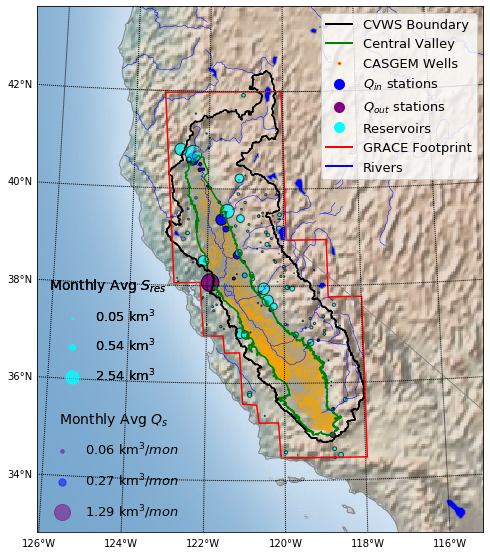

In [15]:
# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(8,12))

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=1.02e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'orange', fill = True)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*70,  color= 'cyan', edgecolor = 'black')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'orange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='blue', lw=2)
                ]

leg1 = ax1.legend(custom_lines, ["CVWS Boundary", 'Central Valley', 
                                 'CASGEM Wells', "$Q_{in}$ stations","$Q_{out}$ stations", 
                                 "Reservoirs",
                                 "GRACE Footprint",
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':13})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    ax1.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', prop={'size':13})
leg2.set_title("Monthly Avg $Q_s$", prop = {'size':14})


# Third legend for reservoir storage
h = [plt.scatter([],[], color="cyan", alpha=0.5, s=rp*70,label=str(round(rp,2)) + ' km$^3$') 
     for rp in [rp1, rp2, rp3]]

leg3 = ax1.legend(handles=h, scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',
            prop={'size':13}, bbox_to_anchor=(0.0, 0.26))
leg3.set_title("Monthly Avg $S_{res}$", prop = {'size':14})


# Add legends
ax1.add_artist(leg1)
ax1.add_artist(leg2)
ax1.add_artist(leg3)

plt.show()

# Figure 2

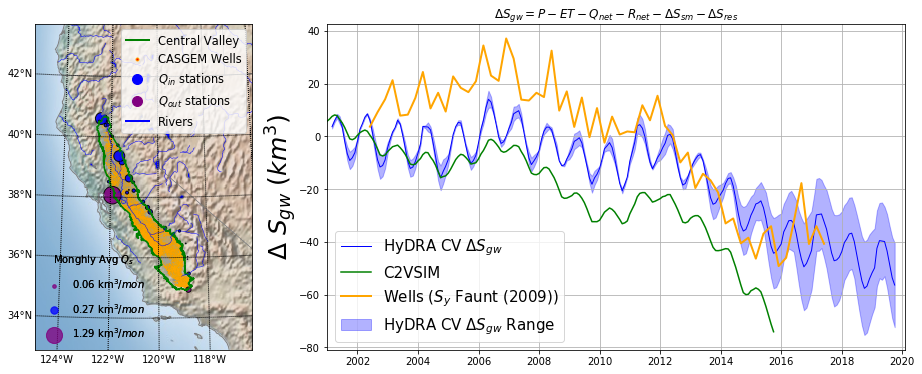

In [16]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'orange', fill = True)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'orange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['Central Valley', 
                                 'CASGEM Wells', 
                                 "$Q_{in}$ stations","$Q_{out}$ stations",  
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':11.5})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    plt.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $Q_s$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
ax2.plot(mdf.index, cvds_mean , color="blue", linewidth = 1, label = "HyDRA CV $\Delta S_{gw}$")
ax2.fill_between(mdf.index, cvds_min, cvds_max, color = 'blue',  alpha = 0.3, label = "HyDRA CV $\Delta S_{gw}$ Range")
ax2.plot(mdf.index, mdf['c2vsim_ds'], color="green", label = "C2VSIM")
ax2.plot(wells.index, wells['wells_ds_km3'],linewidth = 2, color="orange", label = "Wells ($S_y$ Faunt (2009))")

ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - R_{net} - \Delta S_{sm} - \Delta S_{res}$")
ax2.set_xlim(mdf.index[0],mdf.index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25, labelpad= 0.01) 
ax2.legend(loc = "lower left",  prop={'size':15})

plt.grid(True)
G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

plt.show()

# Figure 2 CVWS 

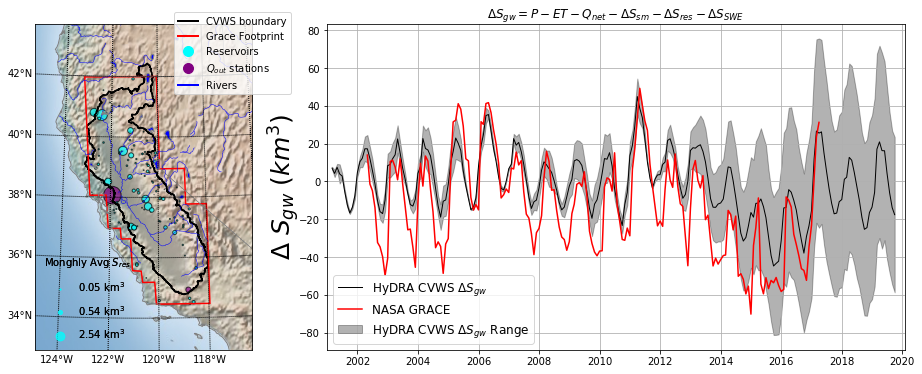

In [17]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(outflow,m, alpha = 0.7, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*30,  color= 'cyan', edgecolor = 'black')


# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['CVWS boundary', 
                                 "Grace Footprint",
                                 "Reservoirs","$Q_{out}$ stations", "Rivers"], 
                    loc = "upper right",
                    prop={'size':10}, 
                    bbox_to_anchor=(1.2, 1.05))

# Make second legend for reservoir storage
for p in [rp1, rp2, rp3]:
    plt.scatter([], [], c='cyan', alpha=0.5, s=p*30,
                label=str(round(p,2)) + ' km$^3$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $S_{res}$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
ax2.plot(mdf.index, cvwds_mean , color="black", linewidth = 1, label = "HyDRA CVWS $\Delta S_{gw}$")
ax2.fill_between(mdf.index, cvwds_min, cvwds_max, color = 'black',  alpha = 0.3, label = "HyDRA CVWS $\Delta S_{gw}$ Range")
ax2.plot(mdf.index, mdf['grace'], color="red", label = "NASA GRACE")

ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$")
ax2.set_xlim(mdf.index[0],mdf.index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25, labelpad= -3.) 
ax2.legend(loc = "lower left",  prop={'size':12})

plt.grid(True)
G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

plt.show()

# Triple Collocation

In [18]:
# Functions to do the math

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) / np.std(src)) * np.std(ref) + np.mean(ref)

# The period of overlap for triple collocation begins with Grace in 04/2003, and ends with C2vSIM in 09/2015

In [19]:
# Make the change in storage into a temporary df
dsdf = pd.DataFrame([cvds_mean, cvwds_mean]).T
dsdf.index = mdf.index
dsdf.columns = ['cvds', 'cvwds']

# Merge with master
tc_df = pd.merge(mdf, dsdf, left_index = True, right_index = True, how = 'outer')

startidx  = tc_df['grace'].dropna().index[0]
endidx  = tc_df['c2vsim_ds'].dropna().index[-1]

In [20]:
tc_mask = (tc_df.index > startidx) & (tc_df.index <= endidx)

rs_ds = tc_df['cvds'][tc_mask].values
wells_ds = tc_df['wells_ds_km3'][tc_mask].interpolate(how = 'linear').values
c2vsim_ds = tc_df['c2vsim_ds'][tc_mask].values
grace_ds = tc_df['grace'][tc_mask].values

In [21]:
tc_dat = [rs_ds, c2vsim_ds, wells_ds, grace_ds]
tc_dict = dict(zip(['HyDRA',  'C2VSim', 'Wells', 'GRACE'], tc_dat))

combos=combinations(tc_dict, 3) 

err_dict = {k:[] for k in tc_dict}

for idx,i in enumerate(combos):

    x = tc_dict[i[0]]
    y = tc_dict[i[1]]
    z = tc_dict[i[2]]
    
    y_scaled = scale_to_ref(y,x)
    z_scaled = scale_to_ref(z,x)

    e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
    
    err_dict[i[0]].append(e_x)
    err_dict[i[1]].append(e_y)
    err_dict[i[2]].append(e_z)
    

In [22]:
mean_errs = {k:np.mean(v) for k,v in err_dict.items()}
std_errs = {k:np.std(v) for k,v in err_dict.items()}

Text(0.5, 0, 'Method of Estimation')

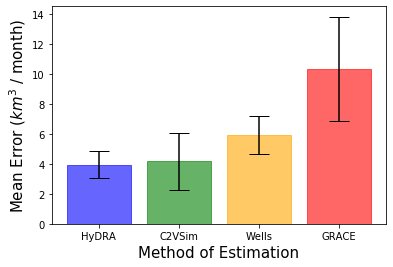

In [23]:
bars = plt.bar(mean_errs.keys(), mean_errs.values(), 
               yerr=list(std_errs.values()),  ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('blue')
bars[1].set_color('green')
bars[2].set_color('orange')
bars[-1].set_color('red')
plt.ylabel("Mean Error ($km^3$ / month)", size = 15)
plt.xlabel("Method of Estimation", size = 15)

# Trendlines during droughts

In [24]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cvds'][df_mask].values
    rscvws = df['cvwds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict


def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals

In [25]:
def get_trendlines(date1,date2):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals

def get_slopes(date1,date2):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],2) for k,v in d.items()}
    
    return polyfits


In [26]:

d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e)
d1s = get_slopes(d1s,d1e)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e)
d2s = get_slopes(d2s,d2e)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e)
rc1s = get_slopes(rc1s,rc1e)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e)
rc2s = get_slopes(rc2s,rc2e)

# Figure 3

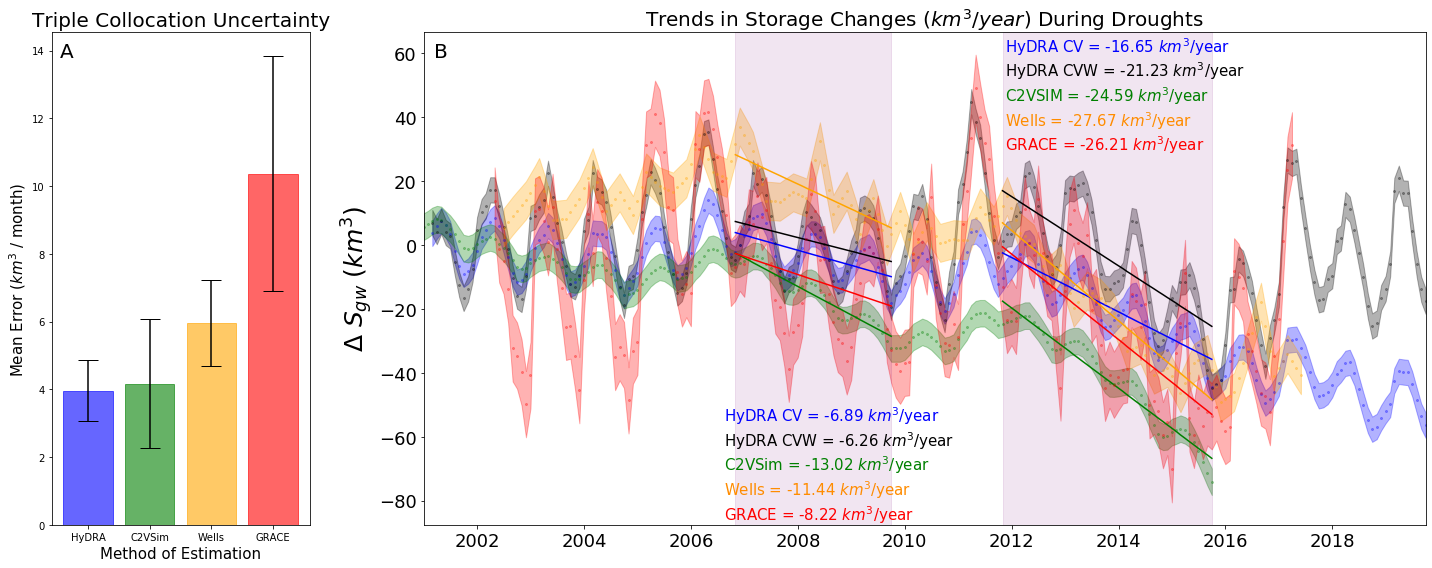

In [27]:
# Plot the TC errors and Timeseries 
# plt.figure(figsize = (16,7))
plt.figure(figsize = (20,8))
plt.title("Trends in Storage Changes ($km^3/year$) During Droughts", size = 20)
G = gridspec.GridSpec(3, 8)

# Plot the TC barchart
ax = plt.subplot(G[:, 0:2])
bars = plt.bar(mean_errs.keys(), mean_errs.values(), 
               yerr=list(std_errs.values()),  ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('blue')
bars[1].set_color('green')
bars[2].set_color('orange')
bars[-1].set_color('red')
plt.ylabel("Mean Error ($km^3$ / month)", size = 15)
plt.xlabel("Method of Estimation", size = 15)

ax.annotate("A", xy=(0.03, 0.95), xycoords="axes fraction", size = 20)
ax.set_title("Triple Collocation Uncertainty", size = 20)

# SEtup time series 
axes_2 = plt.subplot(G[0:, 2:])
axes_2.set_title("Trends in Storage Changes ($km^3/year$) During Droughts", size = 20)


# CV
axes_2.plot(tc_df.index,tc_df['cvds'], 'o', color = 'blue', ms=2, alpha = 0.3, label = "HyDRA CV")
axes_2.fill_between(tc_df.index,tc_df['cvds'] - mean_errs['HyDRA'], tc_df['cvds'] + mean_errs['HyDRA'], 
                    color = 'blue', alpha = 0.3, label = "HyDRA CV Uncertainty")
axes_2.plot(d1t['HyDRAcv'], color = 'blue') # trendline 
axes_2.plot(d2t['HyDRAcv'], color = 'blue') # trendline 


# CVWS
axes_2.plot(tc_df.index,tc_df['cvwds'], 'o', color = 'black', ms=2, alpha = 0.3, label = "HyDRA CVWS")
axes_2.fill_between(tc_df.index,tc_df['cvwds'] - mean_errs['HyDRA'], tc_df['cvwds'] + mean_errs['HyDRA'],
                    color = 'black', alpha = 0.3, label = "HyDRA CVWS Uncertainty")
axes_2.plot(d1t['HyDRAcvws'], color = 'black') # trendline 
axes_2.plot(d2t['HyDRAcvws'], color = 'black') # trendline 


# C2VSIm
axes_2.plot(tc_df.index,tc_df['c2vsim_ds'], 'o', color = 'green', ms=2, alpha = 0.3, label = "C2VSim")
axes_2.fill_between(tc_df.index,tc_df['c2vsim_ds'] - mean_errs['C2VSim'], tc_df['c2vsim_ds'] + mean_errs['C2VSim'],
                    color = 'green', alpha = 0.3, label = "C2VSim Uncertainty")
axes_2.plot(d1t['C2VSim'], color = 'green') # trendline 
axes_2.plot(d2t['C2VSim'], color = 'green') # trendline 


# Wells
winterp = tc_df['wells_ds_km3'].interpolate(how = 'linear')
well_mask = (winterp.index > tc_df['wells_ds_km3'].dropna().index[0]) & (winterp.index <= tc_df['wells_ds_km3'].dropna().index[-1])
winterp = winterp[well_mask]
axes_2.plot(winterp.index,winterp, 'o', color = 'orange', ms=2, alpha = 0.3, label = "Wells")
plt.fill_between(winterp.index, winterp - mean_errs['Wells'], winterp+ mean_errs['Wells'],
                    color = 'orange', alpha = 0.3, label = "Wells Uncertainty")
axes_2.plot(d1t['Wells'], color = 'orange') # trendline 
axes_2.plot(d2t['Wells'], color = 'orange') # trendline 


# GRACE
axes_2.plot(tc_df.index,tc_df['grace'], 'o', color = 'red', ms=2, alpha = 0.3, label = "GRACE")
axes_2.fill_between(tc_df.index,tc_df['grace'] - mean_errs['GRACE'], tc_df['grace'] + mean_errs['GRACE'],
                    color = 'red', alpha = 0.3, label = "GRACE Uncertainty")
axes_2.plot(d1t['GRACE'], color = 'red') # trendline 
axes_2.plot(d2t['GRACE'], color = 'red') # trendline 

# X limits 
axes_2.set_xlim(tc_df.index[0],tc_df.index[-5])
axes_2.annotate("B", xy=(0.01, 0.95), xycoords="axes fraction", size = 20)

# Labels and legend 
axes_2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_2.tick_params(axis='both', which='major', labelsize=18)

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d1s['HyDRAcv']),xy=(0.30, 0.21), color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d1s['HyDRAcvws']),xy=(0.30, 0.16),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSim = {} $km^3$/year".format(d1s['C2VSim']),xy=(0.30, 0.11), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d1s['Wells']),xy=(0.30, 0.06), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d1s['GRACE']),xy=(0.30, 0.01), color = 'red',xycoords="axes fraction", size = 15)

axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d2s['HyDRAcv']),xy=(0.58, 0.96),color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d2s['HyDRAcvws']),xy=(0.58, 0.91),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSIM = {} $km^3$/year".format(d2s['C2VSim']),xy=(0.58, 0.86), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d2s['Wells']),xy=(0.58, 0.81), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d2s['GRACE']),xy=(0.58, 0.76), color = 'red',xycoords="axes fraction", size = 15)


axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')

plt.tight_layout()

In [28]:
# Get the detailed info for the table

In [29]:
ww1start = '2005-10-01'
ww1end = '2006-09-30'
print(ww1start)
w1d = filt_df_dates(tc_df, ww1start, ww1end)
w1out = {k:fit_trend(v) for k,v in w1d.items()}
for k,v in w1out.items():
    print(k, v[1])


d1start = '2006-10-01'
d1end = '2009-09-30'
print(d1start)
d1d = filt_df_dates(tc_df, d1start, d1end)
d1out = {k:fit_trend(v) for k,v in d1d.items()}
for k,v in d1out.items():
    print(k, v[1]*3)

ww2start = '2009-10-01'
ww2end = '2011-09-30'
print(ww2start)
w2d = filt_df_dates(tc_df, ww2start, ww2end)
w2out= {k:fit_trend(v) for k,v in w2d.items()}
for k,v in w2out.items():
    print(k, v[1]*2)

d2start = '2011-10-01'
d2end = '2015-09-30'
print(d2start)
d2d = filt_df_dates(tc_df, d2start, d2end)
d2out = {k:fit_trend(v) for k,v in d2d.items()}
for k,v in d2out.items():
    print(k, v[1]*4)

    
ww3start = '2016-10-01'
ww3end = '2017-09-30'
print(ww3start)
w3d = filt_df_dates(tc_df, ww3start, ww3end)
w3out = {}
for k,v in w3d.items():
    try:
        w3out[k] = fit_trend(v)
    except:
        continue

print(w3out)

2005-10-01
HyDRAcv 4.63760287143073
HyDRAcvws 4.395046848365734
C2VSim 3.5687946341302856
Wells -0.48395930116346086
GRACE 9.779372346605435
2006-10-01
HyDRAcv -20.682613930372167
HyDRAcvws -18.774883686779496
C2VSim -39.06433643085893
Wells -34.33398191001095
GRACE -24.665750845248443
2009-10-01
HyDRAcv 8.077731143868004
HyDRAcvws 25.255685724194542
C2VSim 9.546432791458088
Wells 3.5591736330773296
GRACE 58.59157322676666
2011-10-01
HyDRAcv -66.61906907529033
HyDRAcvws -84.90832464523046
C2VSim -98.3786785290834
Wells -110.67665118161298
GRACE -104.85689395064868
2016-10-01
{'HyDRAcv': (poly1d([  0.17251873, -39.37917111]), 0.9488530320589135), 'HyDRAcvws': (poly1d([ 0.88073385, -4.02088952]), 4.844036195911807), 'Wells': (poly1d([ -0.49709396, -35.71808217]), -2.734016803375006)}
